In [1]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import datetime
from PIL import Image
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model


In [2]:
def plot_training_curves(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_accuracy'] + history.history['accuracy']),
                        max(history.history['val_accuracy'] + history.history['accuracy']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['accuracy']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['accuracy'], label = 'accuracy')
    ax[1].plot(index, history.history['val_accuracy'], label = 'val_accuracy')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# train and test sets for digits 0-9
x_train = x_train/ 255.
x_test = x_test/ 255.

In [6]:
# reshape to add color channel
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

In [8]:
num_classes=10
filters=32
pool_size=2
kernel_size=3
dropout=0.2
input_shape = (28,28,1)

model = Sequential([
      # convolutional feature extraction
      # ConvNet 1
      keras.layers.Conv2D(filters, kernel_size, padding = 'valid',
              activation='relu',
              input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=pool_size),

      # ConvNet 2
      keras.layers.Conv2D(filters, kernel_size,
              padding = 'valid',
              activation='relu'),
      keras.layers.MaxPooling2D(pool_size=pool_size),

      # classification 
      # will retrain from here
      keras.layers.Flatten(name='flatten'),

      keras.layers.Dropout(dropout),
      keras.layers.Dense(128, activation='relu'),
      
      keras.layers.Dropout(dropout, name='penult'),
      keras.layers.Dense(num_classes, activation='softmax', name='last')
  ])

es = keras.callbacks.EarlyStopping(min_delta=0.001, patience=2)

model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam', #sgd, nadam, adam, rmsprop
                      metrics=['accuracy'])

model_digits = model.fit(x_train, y_train,
                              validation_data=(x_test, y_test),
                              batch_size=32,
                              epochs=1000,
                              callbacks=[es])

Epoch 1/1000
1875/1875 [==============================] - 25s 13ms/step - loss: 0.3685 - accuracy: 0.8851 - val_loss: 0.0459 - val_accuracy: 0.9849
Epoch 2/1000
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0652 - accuracy: 0.9799 - val_loss: 0.0343 - val_accuracy: 0.9879
Epoch 3/1000
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0476 - accuracy: 0.9856 - val_loss: 0.0301 - val_accuracy: 0.9889
Epoch 4/1000
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0380 - accuracy: 0.9882 - val_loss: 0.0302 - val_accuracy: 0.9889
Epoch 5/1000
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0340 - accuracy: 0.9891 - val_loss: 0.0230 - val_accuracy: 0.9915
Epoch 6/1000
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0286 - accuracy: 0.9911 - val_loss: 0.0259 - val_accuracy: 0.9916
Epoch 7/1000
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0249 - accuracy: 0.9920 - val_

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

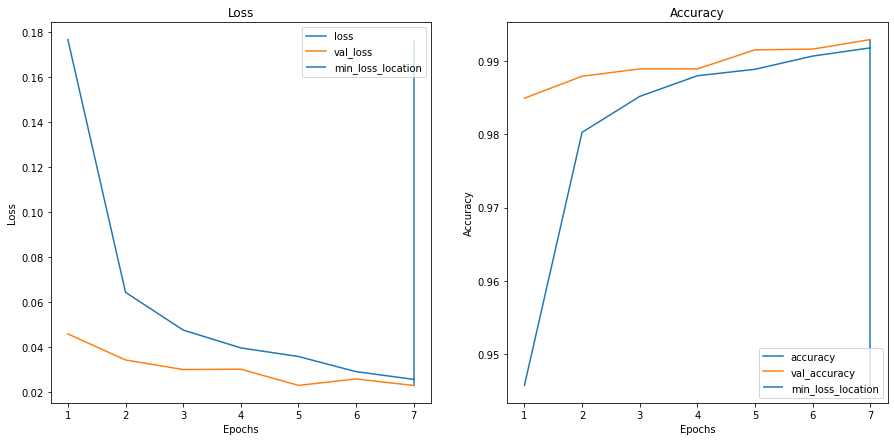

In [10]:
plot_training_curves(model_digits)

## Tranfer learning with emnist dataset

In [11]:
# Load emnist dataset

from emnist import extract_samples
# load Alphabets data, split between train and test sets
(x_letter_train, y_letter_train) = extract_samples('letters', 'train')
(x_letter_test, y_letter_test) = extract_samples('letters', 'test')

# adjust the output labels for alphabets 'A', 'B', 'C', 'D', 'E'
x_letter_train_lt6 = x_letter_train[y_letter_train < 6]
y_letter_train_lt6 = y_letter_train[y_letter_train < 6] - 1
x_letter_test_lt6 = x_letter_test[y_letter_test < 6]
y_letter_test_lt6 = y_letter_test[y_letter_test < 6] - 1

In [12]:
# train and test sets for digits 0-6
x_letter_train_lt6 = x_letter_train_lt6/ 255.
x_letter_test_lt6 = x_letter_test_lt6/ 255.

In [13]:
# lock the ConvNet layers
layer_trainable = False
for layer in model.layers:
  layer.trainable = layer_trainable
  if layer.name == 'flatten':
    layer_trainable = True

print(f"{'Layer Name':17} {'Is Trainable?'}")
for layer in model.layers:
  print(f"{layer.name:17} {layer.trainable}")

Layer Name        Is Trainable?
conv2d            False
max_pooling2d     False
conv2d_1          False
max_pooling2d_1   False
flatten           False
dropout           True
dense             True
penult            True
last              True


In [14]:
# get the penultimate layer of the model
penult_layer = model.get_layer(name='penult')

# create a new output layer
output_layer = keras.layers.Dense(5, activation='softmax')(penult_layer.output)

new_model = Model(model.input, output_layer)

In [15]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0     

In [16]:
new_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

letters_model = new_model.fit(x_letter_train_lt6, y_letter_train_lt6,
                              validation_data=(x_letter_test_lt6, y_letter_test_lt6),
                              batch_size=32,
                              epochs=1000,
                              callbacks=[es])

Epoch 1/1000
750/750 [==============================] - 9s 11ms/step - loss: 0.5506 - accuracy: 0.8105 - val_loss: 0.0972 - val_accuracy: 0.9707
Epoch 2/1000
750/750 [==============================] - 5s 7ms/step - loss: 0.0990 - accuracy: 0.9678 - val_loss: 0.0758 - val_accuracy: 0.9785
Epoch 3/1000
750/750 [==============================] - 5s 6ms/step - loss: 0.0657 - accuracy: 0.9794 - val_loss: 0.0661 - val_accuracy: 0.9812
Epoch 4/1000
750/750 [==============================] - 5s 6ms/step - loss: 0.0564 - accuracy: 0.9824 - val_loss: 0.0621 - val_accuracy: 0.9810
Epoch 5/1000
750/750 [==============================] - 4s 6ms/step - loss: 0.0485 - accuracy: 0.9835 - val_loss: 0.0629 - val_accuracy: 0.9810
Epoch 6/1000
750/750 [==============================] - 4s 5ms/step - loss: 0.0429 - accuracy: 0.9859 - val_loss: 0.0619 - val_accuracy: 0.9815


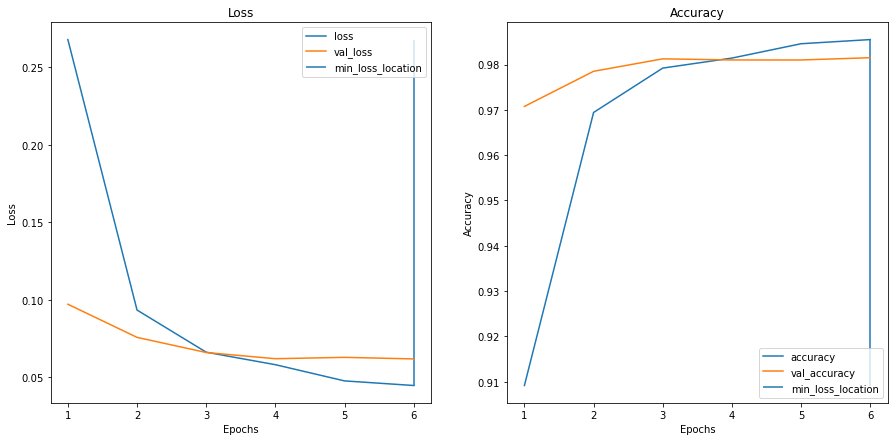

In [17]:
plot_training_curves(history=letters_model)

## Tranfer learning with own handwrittern dataset

In [18]:
def read_images(folder_name):
    size = (28,28)
    folders = glob.glob(folder_name)
    y_let = []
    imagenames_list = []
    target = 0
    prev_folder = folders[0]
    
    for folder in folders:
        for f in glob.glob(folder+'/*'):
            imagenames_list.append(f)
            if prev_folder == folder:
                y_let.append(target)
            else:
                target = target + 1
                y_let.append(target)
                prev_folder = folder
            
    read_images = []        
    for file_name in imagenames_list:
        im = Image.open(file_name).convert("L").resize(size)
        read_images.append(np.array(im))
    
    return read_images, y_let

In [19]:
x_train_let, y_train_let = read_images('data/train/*')
x_test_let, y_test_let = read_images('data/test/*')

In [20]:
# "stack" all trainig and test images 
x_train_letters = np.stack(x_train_let)/255.
x_test_letters = np.stack(x_test_let)/255.
y_train_letters = np.array(y_train_let) 
y_test_letters = np.array(y_test_let) 
print(x_train_letters.shape)
print(y_train_letters.shape)

(134, 28, 28)
(134,)


In [21]:
# add the color channel
x_train_letters = x_train_letters.reshape(x_train_letters.shape + (1,))
x_test_letters = x_test_letters.reshape(x_test_letters.shape + (1,))
print(x_train_letters.shape)
print(x_test_letters.shape)

(134, 28, 28, 1)
(26, 28, 28, 1)


In [29]:
new_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

letters_model = new_model.fit(x_train_letters, y_train_letters,
                              validation_data=(x_test_letters, y_test_letters),
                              batch_size=32,
                              epochs=6000)

#,
#                              callbacks=[es])

Epoch 1/6000
5/5 [==============================] - 0s 44ms/step - loss: 1.5600 - accuracy: 0.3378 - val_loss: 1.6607 - val_accuracy: 0.1923
Epoch 2/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5801 - accuracy: 0.3052 - val_loss: 1.6604 - val_accuracy: 0.1923
Epoch 3/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5560 - accuracy: 0.3412 - val_loss: 1.6608 - val_accuracy: 0.1923
Epoch 4/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5690 - accuracy: 0.3191 - val_loss: 1.6609 - val_accuracy: 0.1923
Epoch 5/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5389 - accuracy: 0.3603 - val_loss: 1.6608 - val_accuracy: 0.1923
Epoch 6/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5488 - accuracy: 0.3451 - val_loss: 1.6605 - val_accuracy: 0.1923
Epoch 7/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5635 - accuracy: 0.3273 - val_loss: 1.6598 - val_accuracy: 0.1923
Epoch 8/6000


Epoch 59/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5681 - accuracy: 0.3213 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 60/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5567 - accuracy: 0.3430 - val_loss: 1.6559 - val_accuracy: 0.1923
Epoch 61/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5632 - accuracy: 0.3278 - val_loss: 1.6558 - val_accuracy: 0.1923
Epoch 62/6000
5/5 [==============================] - 0s 29ms/step - loss: 1.5633 - accuracy: 0.3247 - val_loss: 1.6562 - val_accuracy: 0.1923
Epoch 63/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5562 - accuracy: 0.3425 - val_loss: 1.6569 - val_accuracy: 0.1923
Epoch 64/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5608 - accuracy: 0.3299 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 65/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5827 - accuracy: 0.2996 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 

5/5 [==============================] - 0s 18ms/step - loss: 1.5729 - accuracy: 0.3182 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 117/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5572 - accuracy: 0.3391 - val_loss: 1.6558 - val_accuracy: 0.1923
Epoch 118/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5711 - accuracy: 0.3182 - val_loss: 1.6553 - val_accuracy: 0.1923
Epoch 119/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5641 - accuracy: 0.3278 - val_loss: 1.6548 - val_accuracy: 0.1923
Epoch 120/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5522 - accuracy: 0.3482 - val_loss: 1.6543 - val_accuracy: 0.1923
Epoch 121/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5741 - accuracy: 0.3121 - val_loss: 1.6537 - val_accuracy: 0.1923
Epoch 122/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5646 - accuracy: 0.3269 - val_loss: 1.6533 - val_accuracy: 0.1923
Epoch 123/6000

5/5 [==============================] - 0s 13ms/step - loss: 1.5816 - accuracy: 0.3039 - val_loss: 1.6605 - val_accuracy: 0.1923
Epoch 174/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5636 - accuracy: 0.3304 - val_loss: 1.6613 - val_accuracy: 0.1923
Epoch 175/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5751 - accuracy: 0.3108 - val_loss: 1.6620 - val_accuracy: 0.1923
Epoch 176/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5941 - accuracy: 0.2831 - val_loss: 1.6620 - val_accuracy: 0.1923
Epoch 177/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5667 - accuracy: 0.3195 - val_loss: 1.6617 - val_accuracy: 0.1923
Epoch 178/6000
5/5 [==============================] - 0s 12ms/step - loss: 1.5608 - accuracy: 0.3347 - val_loss: 1.6615 - val_accuracy: 0.1923
Epoch 179/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5602 - accuracy: 0.3330 - val_loss: 1.6611 - val_accuracy: 0.1923
Epoch 180/6000

5/5 [==============================] - 0s 14ms/step - loss: 1.5693 - accuracy: 0.3182 - val_loss: 1.6598 - val_accuracy: 0.1923
Epoch 231/6000
5/5 [==============================] - 0s 12ms/step - loss: 1.5769 - accuracy: 0.3134 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 232/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5861 - accuracy: 0.2943 - val_loss: 1.6597 - val_accuracy: 0.1923
Epoch 233/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5667 - accuracy: 0.3317 - val_loss: 1.6599 - val_accuracy: 0.1923
Epoch 234/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5575 - accuracy: 0.3330 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 235/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5453 - accuracy: 0.3508 - val_loss: 1.6598 - val_accuracy: 0.1923
Epoch 236/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5669 - accuracy: 0.3208 - val_loss: 1.6596 - val_accuracy: 0.1923
Epoch 237/6000

5/5 [==============================] - 0s 14ms/step - loss: 1.5728 - accuracy: 0.3134 - val_loss: 1.6601 - val_accuracy: 0.1923
Epoch 288/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5842 - accuracy: 0.2974 - val_loss: 1.6601 - val_accuracy: 0.1923
Epoch 289/6000
5/5 [==============================] - 0s 12ms/step - loss: 1.5772 - accuracy: 0.3030 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 290/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5311 - accuracy: 0.3820 - val_loss: 1.6604 - val_accuracy: 0.1923
Epoch 291/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5520 - accuracy: 0.3399 - val_loss: 1.6602 - val_accuracy: 0.1923
Epoch 292/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5766 - accuracy: 0.3074 - val_loss: 1.6602 - val_accuracy: 0.1923
Epoch 293/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5929 - accuracy: 0.2844 - val_loss: 1.6606 - val_accuracy: 0.1923
Epoch 294/6000

5/5 [==============================] - 0s 13ms/step - loss: 1.5644 - accuracy: 0.3291 - val_loss: 1.6552 - val_accuracy: 0.1923
Epoch 345/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5657 - accuracy: 0.3269 - val_loss: 1.6550 - val_accuracy: 0.1923
Epoch 346/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5574 - accuracy: 0.3382 - val_loss: 1.6548 - val_accuracy: 0.1923
Epoch 347/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5578 - accuracy: 0.3404 - val_loss: 1.6546 - val_accuracy: 0.1923
Epoch 348/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5472 - accuracy: 0.3534 - val_loss: 1.6549 - val_accuracy: 0.1923
Epoch 349/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5847 - accuracy: 0.2957 - val_loss: 1.6550 - val_accuracy: 0.1923
Epoch 350/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5666 - accuracy: 0.3217 - val_loss: 1.6554 - val_accuracy: 0.1923
Epoch 351/6000

5/5 [==============================] - 0s 13ms/step - loss: 1.5714 - accuracy: 0.3134 - val_loss: 1.6558 - val_accuracy: 0.1923
Epoch 402/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5659 - accuracy: 0.3265 - val_loss: 1.6559 - val_accuracy: 0.1923
Epoch 403/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5518 - accuracy: 0.3464 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 404/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5502 - accuracy: 0.3438 - val_loss: 1.6563 - val_accuracy: 0.1923
Epoch 405/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5436 - accuracy: 0.3590 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 406/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5666 - accuracy: 0.3217 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 407/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5672 - accuracy: 0.3226 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 408/6000

5/5 [==============================] - 0s 13ms/step - loss: 1.5670 - accuracy: 0.3243 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 459/6000
5/5 [==============================] - 0s 10ms/step - loss: 1.5790 - accuracy: 0.3030 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 460/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5846 - accuracy: 0.2961 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 461/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5452 - accuracy: 0.3542 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 462/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5470 - accuracy: 0.3547 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 463/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5549 - accuracy: 0.3369 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 464/6000
5/5 [==============================] - 0s 26ms/step - loss: 1.5544 - accuracy: 0.3469 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 465/6000

5/5 [==============================] - 0s 14ms/step - loss: 1.5592 - accuracy: 0.3373 - val_loss: 1.6520 - val_accuracy: 0.1923
Epoch 516/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5575 - accuracy: 0.3382 - val_loss: 1.6520 - val_accuracy: 0.1923
Epoch 517/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5644 - accuracy: 0.3243 - val_loss: 1.6522 - val_accuracy: 0.1923
Epoch 518/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5524 - accuracy: 0.3508 - val_loss: 1.6525 - val_accuracy: 0.1923
Epoch 519/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5650 - accuracy: 0.3256 - val_loss: 1.6530 - val_accuracy: 0.1923
Epoch 520/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5738 - accuracy: 0.3121 - val_loss: 1.6537 - val_accuracy: 0.1923
Epoch 521/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5475 - accuracy: 0.3529 - val_loss: 1.6548 - val_accuracy: 0.1923
Epoch 522/6000

5/5 [==============================] - 0s 14ms/step - loss: 1.5690 - accuracy: 0.3239 - val_loss: 1.6595 - val_accuracy: 0.1923
Epoch 573/6000
5/5 [==============================] - 0s 12ms/step - loss: 1.5905 - accuracy: 0.2939 - val_loss: 1.6596 - val_accuracy: 0.1923
Epoch 574/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5515 - accuracy: 0.3499 - val_loss: 1.6601 - val_accuracy: 0.1923
Epoch 575/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5683 - accuracy: 0.3230 - val_loss: 1.6604 - val_accuracy: 0.1923
Epoch 576/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5544 - accuracy: 0.3404 - val_loss: 1.6606 - val_accuracy: 0.1923
Epoch 577/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5834 - accuracy: 0.2987 - val_loss: 1.6603 - val_accuracy: 0.1923
Epoch 578/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5991 - accuracy: 0.2805 - val_loss: 1.6599 - val_accuracy: 0.1923
Epoch 579/6000

5/5 [==============================] - 0s 14ms/step - loss: 1.5450 - accuracy: 0.3555 - val_loss: 1.6591 - val_accuracy: 0.1923
Epoch 630/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5726 - accuracy: 0.3121 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 631/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5858 - accuracy: 0.2974 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 632/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5733 - accuracy: 0.3100 - val_loss: 1.6595 - val_accuracy: 0.1923
Epoch 633/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5504 - accuracy: 0.3464 - val_loss: 1.6598 - val_accuracy: 0.1923
Epoch 634/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5613 - accuracy: 0.3308 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 635/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5739 - accuracy: 0.3104 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 636/6000

5/5 [==============================] - 0s 27ms/step - loss: 1.5561 - accuracy: 0.3399 - val_loss: 1.6641 - val_accuracy: 0.1923
Epoch 687/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5368 - accuracy: 0.3660 - val_loss: 1.6637 - val_accuracy: 0.1923
Epoch 688/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5450 - accuracy: 0.3516 - val_loss: 1.6632 - val_accuracy: 0.1923
Epoch 689/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5662 - accuracy: 0.3291 - val_loss: 1.6627 - val_accuracy: 0.1923
Epoch 690/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5835 - accuracy: 0.3004 - val_loss: 1.6623 - val_accuracy: 0.1923
Epoch 691/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5518 - accuracy: 0.3425 - val_loss: 1.6621 - val_accuracy: 0.1923
Epoch 692/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5805 - accuracy: 0.3009 - val_loss: 1.6617 - val_accuracy: 0.1923
Epoch 693/6000

5/5 [==============================] - 0s 14ms/step - loss: 1.5478 - accuracy: 0.3529 - val_loss: 1.6565 - val_accuracy: 0.1923
Epoch 744/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5311 - accuracy: 0.3772 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 745/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5538 - accuracy: 0.3421 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 746/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5499 - accuracy: 0.3477 - val_loss: 1.6559 - val_accuracy: 0.1923
Epoch 747/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5600 - accuracy: 0.3338 - val_loss: 1.6557 - val_accuracy: 0.1923
Epoch 748/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5701 - accuracy: 0.3178 - val_loss: 1.6555 - val_accuracy: 0.1923
Epoch 749/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5696 - accuracy: 0.3165 - val_loss: 1.6554 - val_accuracy: 0.1923
Epoch 750/6000

5/5 [==============================] - 0s 30ms/step - loss: 1.5536 - accuracy: 0.3382 - val_loss: 1.6546 - val_accuracy: 0.1923
Epoch 801/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5670 - accuracy: 0.3234 - val_loss: 1.6547 - val_accuracy: 0.1923
Epoch 802/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5691 - accuracy: 0.3213 - val_loss: 1.6549 - val_accuracy: 0.1923
Epoch 803/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5900 - accuracy: 0.2835 - val_loss: 1.6552 - val_accuracy: 0.1923
Epoch 804/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5572 - accuracy: 0.3378 - val_loss: 1.6557 - val_accuracy: 0.1923
Epoch 805/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5663 - accuracy: 0.3217 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 806/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5413 - accuracy: 0.3625 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 807/6000

5/5 [==============================] - 0s 11ms/step - loss: 1.5696 - accuracy: 0.3160 - val_loss: 1.6576 - val_accuracy: 0.1923
Epoch 858/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5755 - accuracy: 0.3104 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 859/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5758 - accuracy: 0.3100 - val_loss: 1.6569 - val_accuracy: 0.1923
Epoch 860/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5795 - accuracy: 0.3035 - val_loss: 1.6569 - val_accuracy: 0.1923
Epoch 861/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5569 - accuracy: 0.3351 - val_loss: 1.6572 - val_accuracy: 0.1923
Epoch 862/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5815 - accuracy: 0.2991 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 863/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5451 - accuracy: 0.3542 - val_loss: 1.6572 - val_accuracy: 0.1923
Epoch 864/6000

5/5 [==============================] - 0s 14ms/step - loss: 1.5782 - accuracy: 0.3082 - val_loss: 1.6574 - val_accuracy: 0.1923
Epoch 915/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5554 - accuracy: 0.3369 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 916/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5648 - accuracy: 0.3239 - val_loss: 1.6581 - val_accuracy: 0.1923
Epoch 917/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5530 - accuracy: 0.3421 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 918/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5556 - accuracy: 0.3425 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 919/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5866 - accuracy: 0.2935 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 920/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5731 - accuracy: 0.3165 - val_loss: 1.6596 - val_accuracy: 0.1923
Epoch 921/6000

5/5 [==============================] - 0s 13ms/step - loss: 1.5743 - accuracy: 0.3069 - val_loss: 1.6606 - val_accuracy: 0.1923
Epoch 972/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5624 - accuracy: 0.3317 - val_loss: 1.6608 - val_accuracy: 0.1923
Epoch 973/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5568 - accuracy: 0.3338 - val_loss: 1.6612 - val_accuracy: 0.1923
Epoch 974/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5274 - accuracy: 0.3781 - val_loss: 1.6614 - val_accuracy: 0.1923
Epoch 975/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5648 - accuracy: 0.3282 - val_loss: 1.6614 - val_accuracy: 0.1923
Epoch 976/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5635 - accuracy: 0.3286 - val_loss: 1.6610 - val_accuracy: 0.1923
Epoch 977/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5494 - accuracy: 0.3469 - val_loss: 1.6608 - val_accuracy: 0.1923
Epoch 978/6000

5/5 [==============================] - 0s 17ms/step - loss: 1.5404 - accuracy: 0.3634 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 1029/6000
5/5 [==============================] - 0s 20ms/step - loss: 1.5741 - accuracy: 0.3139 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 1030/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5538 - accuracy: 0.3412 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 1031/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5730 - accuracy: 0.3143 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 1032/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5717 - accuracy: 0.3165 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 1033/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5737 - accuracy: 0.3178 - val_loss: 1.6573 - val_accuracy: 0.1923
Epoch 1034/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5766 - accuracy: 0.3074 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 10

Epoch 1085/6000
5/5 [==============================] - 0s 22ms/step - loss: 1.5549 - accuracy: 0.3378 - val_loss: 1.6546 - val_accuracy: 0.1923
Epoch 1086/6000
5/5 [==============================] - 0s 22ms/step - loss: 1.5732 - accuracy: 0.3069 - val_loss: 1.6547 - val_accuracy: 0.1923
Epoch 1087/6000
5/5 [==============================] - 0s 23ms/step - loss: 1.5800 - accuracy: 0.3039 - val_loss: 1.6549 - val_accuracy: 0.1923
Epoch 1088/6000
5/5 [==============================] - 0s 30ms/step - loss: 1.5726 - accuracy: 0.3213 - val_loss: 1.6550 - val_accuracy: 0.1923
Epoch 1089/6000
5/5 [==============================] - 0s 26ms/step - loss: 1.5806 - accuracy: 0.3087 - val_loss: 1.6555 - val_accuracy: 0.1923
Epoch 1090/6000
5/5 [==============================] - 0s 29ms/step - loss: 1.5683 - accuracy: 0.3239 - val_loss: 1.6559 - val_accuracy: 0.1923
Epoch 1091/6000
5/5 [==============================] - 0s 31ms/step - loss: 1.5497 - accuracy: 0.3473 - val_loss: 1.6563 - val_accuracy:

Epoch 1142/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5672 - accuracy: 0.3265 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 1143/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5662 - accuracy: 0.3269 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 1144/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5594 - accuracy: 0.3299 - val_loss: 1.6568 - val_accuracy: 0.1923
Epoch 1145/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5657 - accuracy: 0.3213 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 1146/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5851 - accuracy: 0.2943 - val_loss: 1.6573 - val_accuracy: 0.1923
Epoch 1147/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5727 - accuracy: 0.3165 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 1148/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5630 - accuracy: 0.3286 - val_loss: 1.6580 - val_accuracy:

5/5 [==============================] - 0s 15ms/step - loss: 1.5754 - accuracy: 0.3095 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 1199/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5445 - accuracy: 0.3568 - val_loss: 1.6595 - val_accuracy: 0.1923
Epoch 1200/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5401 - accuracy: 0.3634 - val_loss: 1.6596 - val_accuracy: 0.1923
Epoch 1201/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5708 - accuracy: 0.3187 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 1202/6000
5/5 [==============================] - 0s 36ms/step - loss: 1.5568 - accuracy: 0.3430 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 1203/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5728 - accuracy: 0.3143 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 1204/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5551 - accuracy: 0.3434 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 12

5/5 [==============================] - 0s 16ms/step - loss: 1.5793 - accuracy: 0.3000 - val_loss: 1.6569 - val_accuracy: 0.1923
Epoch 1256/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5975 - accuracy: 0.2800 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 1257/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5823 - accuracy: 0.3000 - val_loss: 1.6573 - val_accuracy: 0.1923
Epoch 1258/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5612 - accuracy: 0.3295 - val_loss: 1.6580 - val_accuracy: 0.1923
Epoch 1259/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5682 - accuracy: 0.3234 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 1260/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5794 - accuracy: 0.3043 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 1261/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5619 - accuracy: 0.3265 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 12

5/5 [==============================] - 0s 15ms/step - loss: 1.5622 - accuracy: 0.3295 - val_loss: 1.6536 - val_accuracy: 0.1923
Epoch 1313/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5754 - accuracy: 0.3108 - val_loss: 1.6537 - val_accuracy: 0.1923
Epoch 1314/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5704 - accuracy: 0.3178 - val_loss: 1.6535 - val_accuracy: 0.1923
Epoch 1315/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5621 - accuracy: 0.3282 - val_loss: 1.6536 - val_accuracy: 0.1923
Epoch 1316/6000
5/5 [==============================] - 0s 30ms/step - loss: 1.5744 - accuracy: 0.3121 - val_loss: 1.6537 - val_accuracy: 0.1923
Epoch 1317/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5655 - accuracy: 0.3286 - val_loss: 1.6537 - val_accuracy: 0.1923
Epoch 1318/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5604 - accuracy: 0.3343 - val_loss: 1.6537 - val_accuracy: 0.1923
Epoch 13

5/5 [==============================] - 0s 14ms/step - loss: 1.5899 - accuracy: 0.2900 - val_loss: 1.6572 - val_accuracy: 0.1923
Epoch 1370/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5583 - accuracy: 0.3347 - val_loss: 1.6573 - val_accuracy: 0.1923
Epoch 1371/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5699 - accuracy: 0.3165 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 1372/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5690 - accuracy: 0.3191 - val_loss: 1.6568 - val_accuracy: 0.1923
Epoch 1373/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5615 - accuracy: 0.3334 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 1374/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5605 - accuracy: 0.3312 - val_loss: 1.6560 - val_accuracy: 0.1923
Epoch 1375/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5537 - accuracy: 0.3417 - val_loss: 1.6560 - val_accuracy: 0.1923
Epoch 13

5/5 [==============================] - 0s 14ms/step - loss: 1.5658 - accuracy: 0.3230 - val_loss: 1.6547 - val_accuracy: 0.1923
Epoch 1427/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5605 - accuracy: 0.3343 - val_loss: 1.6544 - val_accuracy: 0.1923
Epoch 1428/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5571 - accuracy: 0.3356 - val_loss: 1.6541 - val_accuracy: 0.1923
Epoch 1429/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5823 - accuracy: 0.2983 - val_loss: 1.6538 - val_accuracy: 0.1923
Epoch 1430/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5570 - accuracy: 0.3391 - val_loss: 1.6542 - val_accuracy: 0.1923
Epoch 1431/6000
5/5 [==============================] - 0s 10ms/step - loss: 1.5474 - accuracy: 0.3590 - val_loss: 1.6546 - val_accuracy: 0.1923
Epoch 1432/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5648 - accuracy: 0.3273 - val_loss: 1.6547 - val_accuracy: 0.1923
Epoch 14

5/5 [==============================] - 0s 14ms/step - loss: 1.5567 - accuracy: 0.3399 - val_loss: 1.6573 - val_accuracy: 0.1923
Epoch 1484/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5822 - accuracy: 0.2974 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 1485/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5836 - accuracy: 0.2957 - val_loss: 1.6569 - val_accuracy: 0.1923
Epoch 1486/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5566 - accuracy: 0.3360 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 1487/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5690 - accuracy: 0.3204 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 1488/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5566 - accuracy: 0.3378 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 1489/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5584 - accuracy: 0.3412 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 14

5/5 [==============================] - 0s 13ms/step - loss: 1.5570 - accuracy: 0.3395 - val_loss: 1.6596 - val_accuracy: 0.1923
Epoch 1541/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5830 - accuracy: 0.3009 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 1542/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5430 - accuracy: 0.3590 - val_loss: 1.6595 - val_accuracy: 0.1923
Epoch 1543/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5800 - accuracy: 0.3000 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 1544/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5697 - accuracy: 0.3221 - val_loss: 1.6595 - val_accuracy: 0.1923
Epoch 1545/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5644 - accuracy: 0.3252 - val_loss: 1.6597 - val_accuracy: 0.1923
Epoch 1546/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5831 - accuracy: 0.2957 - val_loss: 1.6599 - val_accuracy: 0.1923
Epoch 15

5/5 [==============================] - 0s 19ms/step - loss: 1.5592 - accuracy: 0.3330 - val_loss: 1.6558 - val_accuracy: 0.1923
Epoch 1598/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5778 - accuracy: 0.3087 - val_loss: 1.6557 - val_accuracy: 0.1923
Epoch 1599/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5726 - accuracy: 0.3143 - val_loss: 1.6558 - val_accuracy: 0.1923
Epoch 1600/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5579 - accuracy: 0.3321 - val_loss: 1.6559 - val_accuracy: 0.1923
Epoch 1601/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5649 - accuracy: 0.3247 - val_loss: 1.6562 - val_accuracy: 0.1923
Epoch 1602/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5643 - accuracy: 0.3221 - val_loss: 1.6563 - val_accuracy: 0.1923
Epoch 1603/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5700 - accuracy: 0.3178 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 16

5/5 [==============================] - 0s 14ms/step - loss: 1.5588 - accuracy: 0.3364 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 1655/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5713 - accuracy: 0.3169 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 1656/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5493 - accuracy: 0.3503 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 1657/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5651 - accuracy: 0.3256 - val_loss: 1.6559 - val_accuracy: 0.1923
Epoch 1658/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5807 - accuracy: 0.3043 - val_loss: 1.6558 - val_accuracy: 0.1923
Epoch 1659/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5746 - accuracy: 0.3113 - val_loss: 1.6556 - val_accuracy: 0.1923
Epoch 1660/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5713 - accuracy: 0.3156 - val_loss: 1.6556 - val_accuracy: 0.1923
Epoch 16

5/5 [==============================] - 0s 14ms/step - loss: 1.5405 - accuracy: 0.3577 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 1712/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5566 - accuracy: 0.3391 - val_loss: 1.6557 - val_accuracy: 0.1923
Epoch 1713/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5751 - accuracy: 0.3108 - val_loss: 1.6554 - val_accuracy: 0.1923
Epoch 1714/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5761 - accuracy: 0.3087 - val_loss: 1.6550 - val_accuracy: 0.1923
Epoch 1715/6000
5/5 [==============================] - 0s 11ms/step - loss: 1.5762 - accuracy: 0.3108 - val_loss: 1.6553 - val_accuracy: 0.1923
Epoch 1716/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5533 - accuracy: 0.3438 - val_loss: 1.6554 - val_accuracy: 0.1923
Epoch 1717/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5755 - accuracy: 0.3095 - val_loss: 1.6558 - val_accuracy: 0.1923
Epoch 17

5/5 [==============================] - 0s 16ms/step - loss: 1.5930 - accuracy: 0.2870 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 1769/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5496 - accuracy: 0.3495 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 1770/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5620 - accuracy: 0.3304 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 1771/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5583 - accuracy: 0.3321 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 1772/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5827 - accuracy: 0.2978 - val_loss: 1.6582 - val_accuracy: 0.1923
Epoch 1773/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5905 - accuracy: 0.2848 - val_loss: 1.6581 - val_accuracy: 0.1923
Epoch 1774/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5729 - accuracy: 0.3121 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 17

5/5 [==============================] - 0s 14ms/step - loss: 1.5567 - accuracy: 0.3399 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 1826/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5659 - accuracy: 0.3230 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 1827/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5651 - accuracy: 0.3230 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 1828/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5613 - accuracy: 0.3308 - val_loss: 1.6572 - val_accuracy: 0.1923
Epoch 1829/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5573 - accuracy: 0.3369 - val_loss: 1.6573 - val_accuracy: 0.1923
Epoch 1830/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5752 - accuracy: 0.3100 - val_loss: 1.6574 - val_accuracy: 0.1923
Epoch 1831/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5750 - accuracy: 0.3117 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 18

5/5 [==============================] - 0s 13ms/step - loss: 1.5791 - accuracy: 0.3052 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 1883/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5582 - accuracy: 0.3347 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 1884/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5605 - accuracy: 0.3286 - val_loss: 1.6595 - val_accuracy: 0.1923
Epoch 1885/6000
5/5 [==============================] - 0s 20ms/step - loss: 1.5649 - accuracy: 0.3278 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 1886/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5638 - accuracy: 0.3299 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 1887/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5596 - accuracy: 0.3373 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 1888/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5365 - accuracy: 0.3647 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 18

5/5 [==============================] - 0s 32ms/step - loss: 1.5400 - accuracy: 0.3660 - val_loss: 1.6597 - val_accuracy: 0.1923
Epoch 1940/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5441 - accuracy: 0.3595 - val_loss: 1.6595 - val_accuracy: 0.1923
Epoch 1941/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5841 - accuracy: 0.2974 - val_loss: 1.6591 - val_accuracy: 0.1923
Epoch 1942/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5724 - accuracy: 0.3126 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 1943/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5542 - accuracy: 0.3382 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 1944/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5849 - accuracy: 0.2952 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 1945/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5661 - accuracy: 0.3260 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 19

5/5 [==============================] - 0s 21ms/step - loss: 1.5815 - accuracy: 0.3000 - val_loss: 1.6562 - val_accuracy: 0.1923
Epoch 1997/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5714 - accuracy: 0.3182 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 1998/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5472 - accuracy: 0.3516 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 1999/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5761 - accuracy: 0.3082 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 2000/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5647 - accuracy: 0.3282 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 2001/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5715 - accuracy: 0.3134 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 2002/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5567 - accuracy: 0.3369 - val_loss: 1.6579 - val_accuracy: 0.1923
Epoch 20

5/5 [==============================] - 0s 20ms/step - loss: 1.5719 - accuracy: 0.3147 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 2054/6000
5/5 [==============================] - 0s 34ms/step - loss: 1.5378 - accuracy: 0.3673 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 2055/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5787 - accuracy: 0.3056 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 2056/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5503 - accuracy: 0.3482 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 2057/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5802 - accuracy: 0.3061 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 2058/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5823 - accuracy: 0.3022 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 2059/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5710 - accuracy: 0.3160 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 20

5/5 [==============================] - 0s 18ms/step - loss: 1.5751 - accuracy: 0.3100 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 2111/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5850 - accuracy: 0.2943 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 2112/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5569 - accuracy: 0.3356 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 2113/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5893 - accuracy: 0.2909 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 2114/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5684 - accuracy: 0.3160 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 2115/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5629 - accuracy: 0.3282 - val_loss: 1.6599 - val_accuracy: 0.1923
Epoch 2116/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5591 - accuracy: 0.3317 - val_loss: 1.6603 - val_accuracy: 0.1923
Epoch 21

5/5 [==============================] - 0s 16ms/step - loss: 1.5558 - accuracy: 0.3391 - val_loss: 1.6612 - val_accuracy: 0.1923
Epoch 2168/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5365 - accuracy: 0.3655 - val_loss: 1.6613 - val_accuracy: 0.1923
Epoch 2169/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5522 - accuracy: 0.3438 - val_loss: 1.6611 - val_accuracy: 0.1923
Epoch 2170/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5471 - accuracy: 0.3564 - val_loss: 1.6606 - val_accuracy: 0.1923
Epoch 2171/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5439 - accuracy: 0.3547 - val_loss: 1.6603 - val_accuracy: 0.1923
Epoch 2172/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5711 - accuracy: 0.3208 - val_loss: 1.6597 - val_accuracy: 0.1923
Epoch 2173/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5641 - accuracy: 0.3260 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 21

5/5 [==============================] - 0s 16ms/step - loss: 1.5704 - accuracy: 0.3195 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 2225/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5915 - accuracy: 0.2861 - val_loss: 1.6591 - val_accuracy: 0.1923
Epoch 2226/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5527 - accuracy: 0.3438 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 2227/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5516 - accuracy: 0.3417 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 2228/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5724 - accuracy: 0.3156 - val_loss: 1.6591 - val_accuracy: 0.1923
Epoch 2229/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5817 - accuracy: 0.2996 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 2230/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5478 - accuracy: 0.3529 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 22

5/5 [==============================] - 0s 15ms/step - loss: 1.5624 - accuracy: 0.3317 - val_loss: 1.6614 - val_accuracy: 0.1923
Epoch 2282/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5831 - accuracy: 0.3004 - val_loss: 1.6612 - val_accuracy: 0.1923
Epoch 2283/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5692 - accuracy: 0.3200 - val_loss: 1.6608 - val_accuracy: 0.1923
Epoch 2284/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5668 - accuracy: 0.3217 - val_loss: 1.6607 - val_accuracy: 0.1923
Epoch 2285/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5914 - accuracy: 0.2870 - val_loss: 1.6603 - val_accuracy: 0.1923
Epoch 2286/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5417 - accuracy: 0.3616 - val_loss: 1.6603 - val_accuracy: 0.1923
Epoch 2287/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5838 - accuracy: 0.2970 - val_loss: 1.6602 - val_accuracy: 0.1923
Epoch 22

5/5 [==============================] - 0s 15ms/step - loss: 1.5843 - accuracy: 0.2948 - val_loss: 1.6556 - val_accuracy: 0.1923
Epoch 2339/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5576 - accuracy: 0.3391 - val_loss: 1.6555 - val_accuracy: 0.1923
Epoch 2340/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5932 - accuracy: 0.2883 - val_loss: 1.6554 - val_accuracy: 0.1923
Epoch 2341/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5617 - accuracy: 0.3295 - val_loss: 1.6555 - val_accuracy: 0.1923
Epoch 2342/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5463 - accuracy: 0.3529 - val_loss: 1.6554 - val_accuracy: 0.1923
Epoch 2343/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.6007 - accuracy: 0.2696 - val_loss: 1.6551 - val_accuracy: 0.1923
Epoch 2344/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5764 - accuracy: 0.3074 - val_loss: 1.6549 - val_accuracy: 0.1923
Epoch 23

5/5 [==============================] - 0s 15ms/step - loss: 1.5667 - accuracy: 0.3260 - val_loss: 1.6545 - val_accuracy: 0.1923
Epoch 2396/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5808 - accuracy: 0.3017 - val_loss: 1.6546 - val_accuracy: 0.1923
Epoch 2397/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5501 - accuracy: 0.3503 - val_loss: 1.6548 - val_accuracy: 0.1923
Epoch 2398/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5937 - accuracy: 0.2787 - val_loss: 1.6550 - val_accuracy: 0.1923
Epoch 2399/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5836 - accuracy: 0.2961 - val_loss: 1.6551 - val_accuracy: 0.1923
Epoch 2400/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5656 - accuracy: 0.3243 - val_loss: 1.6553 - val_accuracy: 0.1923
Epoch 2401/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5692 - accuracy: 0.3187 - val_loss: 1.6557 - val_accuracy: 0.1923
Epoch 24

5/5 [==============================] - 0s 14ms/step - loss: 1.5753 - accuracy: 0.3121 - val_loss: 1.6560 - val_accuracy: 0.1923
Epoch 2453/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5358 - accuracy: 0.3690 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 2454/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5621 - accuracy: 0.3321 - val_loss: 1.6560 - val_accuracy: 0.1923
Epoch 2455/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5590 - accuracy: 0.3334 - val_loss: 1.6559 - val_accuracy: 0.1923
Epoch 2456/6000
5/5 [==============================] - 0s 29ms/step - loss: 1.5677 - accuracy: 0.3213 - val_loss: 1.6558 - val_accuracy: 0.1923
Epoch 2457/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5473 - accuracy: 0.3503 - val_loss: 1.6560 - val_accuracy: 0.1923
Epoch 2458/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5866 - accuracy: 0.2909 - val_loss: 1.6559 - val_accuracy: 0.1923
Epoch 24

5/5 [==============================] - 0s 15ms/step - loss: 1.5609 - accuracy: 0.3247 - val_loss: 1.6580 - val_accuracy: 0.1923
Epoch 2510/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5517 - accuracy: 0.3460 - val_loss: 1.6580 - val_accuracy: 0.1923
Epoch 2511/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5793 - accuracy: 0.3061 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 2512/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5622 - accuracy: 0.3269 - val_loss: 1.6577 - val_accuracy: 0.1923
Epoch 2513/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5551 - accuracy: 0.3417 - val_loss: 1.6577 - val_accuracy: 0.1923
Epoch 2514/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5689 - accuracy: 0.3187 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 2515/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5650 - accuracy: 0.3252 - val_loss: 1.6579 - val_accuracy: 0.1923
Epoch 25

5/5 [==============================] - 0s 14ms/step - loss: 1.5598 - accuracy: 0.3364 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 2567/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5690 - accuracy: 0.3187 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 2568/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5476 - accuracy: 0.3538 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 2569/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5651 - accuracy: 0.3286 - val_loss: 1.6591 - val_accuracy: 0.1923
Epoch 2570/6000
5/5 [==============================] - 0s 28ms/step - loss: 1.5728 - accuracy: 0.3156 - val_loss: 1.6591 - val_accuracy: 0.1923
Epoch 2571/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5759 - accuracy: 0.3100 - val_loss: 1.6591 - val_accuracy: 0.1923
Epoch 2572/6000
5/5 [==============================] - 0s 12ms/step - loss: 1.5741 - accuracy: 0.3069 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 25

5/5 [==============================] - 0s 14ms/step - loss: 1.5756 - accuracy: 0.3113 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 2624/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5717 - accuracy: 0.3160 - val_loss: 1.6599 - val_accuracy: 0.1923
Epoch 2625/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5662 - accuracy: 0.3252 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 2626/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5771 - accuracy: 0.3069 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 2627/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5708 - accuracy: 0.3182 - val_loss: 1.6601 - val_accuracy: 0.1923
Epoch 2628/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5703 - accuracy: 0.3208 - val_loss: 1.6604 - val_accuracy: 0.1923
Epoch 2629/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5735 - accuracy: 0.3126 - val_loss: 1.6605 - val_accuracy: 0.1923
Epoch 26

5/5 [==============================] - 0s 14ms/step - loss: 1.5814 - accuracy: 0.3013 - val_loss: 1.6623 - val_accuracy: 0.1923
Epoch 2681/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5323 - accuracy: 0.3720 - val_loss: 1.6623 - val_accuracy: 0.1923
Epoch 2682/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5617 - accuracy: 0.3338 - val_loss: 1.6623 - val_accuracy: 0.1923
Epoch 2683/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5393 - accuracy: 0.3621 - val_loss: 1.6623 - val_accuracy: 0.1923
Epoch 2684/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5614 - accuracy: 0.3273 - val_loss: 1.6624 - val_accuracy: 0.1923
Epoch 2685/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5688 - accuracy: 0.3195 - val_loss: 1.6623 - val_accuracy: 0.1923
Epoch 2686/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5513 - accuracy: 0.3447 - val_loss: 1.6622 - val_accuracy: 0.1923
Epoch 26

5/5 [==============================] - 0s 15ms/step - loss: 1.5657 - accuracy: 0.3282 - val_loss: 1.6603 - val_accuracy: 0.1923
Epoch 2738/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5494 - accuracy: 0.3469 - val_loss: 1.6602 - val_accuracy: 0.1923
Epoch 2739/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5579 - accuracy: 0.3356 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 2740/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5508 - accuracy: 0.3460 - val_loss: 1.6598 - val_accuracy: 0.1923
Epoch 2741/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5584 - accuracy: 0.3343 - val_loss: 1.6596 - val_accuracy: 0.1923
Epoch 2742/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5807 - accuracy: 0.3069 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 2743/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5683 - accuracy: 0.3187 - val_loss: 1.6595 - val_accuracy: 0.1923
Epoch 27

5/5 [==============================] - 0s 17ms/step - loss: 1.5680 - accuracy: 0.3247 - val_loss: 1.6617 - val_accuracy: 0.1923
Epoch 2795/6000
5/5 [==============================] - 0s 22ms/step - loss: 1.5644 - accuracy: 0.3260 - val_loss: 1.6620 - val_accuracy: 0.1923
Epoch 2796/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5597 - accuracy: 0.3317 - val_loss: 1.6622 - val_accuracy: 0.1923
Epoch 2797/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5952 - accuracy: 0.2848 - val_loss: 1.6622 - val_accuracy: 0.1923
Epoch 2798/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5853 - accuracy: 0.2904 - val_loss: 1.6622 - val_accuracy: 0.1923
Epoch 2799/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5839 - accuracy: 0.2957 - val_loss: 1.6623 - val_accuracy: 0.1923
Epoch 2800/6000
5/5 [==============================] - 0s 12ms/step - loss: 1.5744 - accuracy: 0.3056 - val_loss: 1.6623 - val_accuracy: 0.1923
Epoch 28

5/5 [==============================] - 0s 17ms/step - loss: 1.5586 - accuracy: 0.3325 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 2852/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5526 - accuracy: 0.3417 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 2853/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5655 - accuracy: 0.3299 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 2854/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5513 - accuracy: 0.3490 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 2855/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5518 - accuracy: 0.3456 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 2856/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5458 - accuracy: 0.3516 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 2857/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5577 - accuracy: 0.3334 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 28

5/5 [==============================] - 0s 19ms/step - loss: 1.5750 - accuracy: 0.3082 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 2909/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5810 - accuracy: 0.3061 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 2910/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5656 - accuracy: 0.3265 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 2911/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5747 - accuracy: 0.3126 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 2912/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5639 - accuracy: 0.3299 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 2913/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5586 - accuracy: 0.3360 - val_loss: 1.6597 - val_accuracy: 0.1923
Epoch 2914/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5657 - accuracy: 0.3273 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 29

5/5 [==============================] - 0s 18ms/step - loss: 1.5603 - accuracy: 0.3325 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 2966/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5550 - accuracy: 0.3391 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 2967/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5599 - accuracy: 0.3360 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 2968/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5557 - accuracy: 0.3378 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 2969/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5700 - accuracy: 0.3152 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 2970/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5598 - accuracy: 0.3338 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 2971/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5746 - accuracy: 0.3104 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 29

5/5 [==============================] - 0s 16ms/step - loss: 1.5621 - accuracy: 0.3312 - val_loss: 1.6565 - val_accuracy: 0.1923
Epoch 3023/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5638 - accuracy: 0.3273 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 3024/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5677 - accuracy: 0.3243 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 3025/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5843 - accuracy: 0.2961 - val_loss: 1.6568 - val_accuracy: 0.1923
Epoch 3026/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5796 - accuracy: 0.3009 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 3027/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5395 - accuracy: 0.3629 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 3028/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5615 - accuracy: 0.3282 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 30

5/5 [==============================] - 0s 15ms/step - loss: 1.5617 - accuracy: 0.3312 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 3080/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5811 - accuracy: 0.3017 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 3081/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5631 - accuracy: 0.3252 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 3082/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5459 - accuracy: 0.3547 - val_loss: 1.6582 - val_accuracy: 0.1923
Epoch 3083/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5591 - accuracy: 0.3299 - val_loss: 1.6582 - val_accuracy: 0.1923
Epoch 3084/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5677 - accuracy: 0.3221 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 3085/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5691 - accuracy: 0.3182 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 30

5/5 [==============================] - 0s 14ms/step - loss: 1.5688 - accuracy: 0.3187 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 3137/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5558 - accuracy: 0.3395 - val_loss: 1.6576 - val_accuracy: 0.1923
Epoch 3138/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5554 - accuracy: 0.3399 - val_loss: 1.6577 - val_accuracy: 0.1923
Epoch 3139/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5603 - accuracy: 0.3356 - val_loss: 1.6577 - val_accuracy: 0.1923
Epoch 3140/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5646 - accuracy: 0.3243 - val_loss: 1.6576 - val_accuracy: 0.1923
Epoch 3141/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5807 - accuracy: 0.3022 - val_loss: 1.6577 - val_accuracy: 0.1923
Epoch 3142/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5636 - accuracy: 0.3265 - val_loss: 1.6579 - val_accuracy: 0.1923
Epoch 31

5/5 [==============================] - 0s 33ms/step - loss: 1.5742 - accuracy: 0.3117 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 3194/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5775 - accuracy: 0.3100 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 3195/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5785 - accuracy: 0.3056 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 3196/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5529 - accuracy: 0.3443 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 3197/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5404 - accuracy: 0.3629 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 3198/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5689 - accuracy: 0.3204 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 3199/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5603 - accuracy: 0.3304 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 32

5/5 [==============================] - 0s 16ms/step - loss: 1.5533 - accuracy: 0.3464 - val_loss: 1.6601 - val_accuracy: 0.1923
Epoch 3251/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5663 - accuracy: 0.3243 - val_loss: 1.6603 - val_accuracy: 0.1923
Epoch 3252/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5642 - accuracy: 0.3299 - val_loss: 1.6603 - val_accuracy: 0.1923
Epoch 3253/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5552 - accuracy: 0.3443 - val_loss: 1.6603 - val_accuracy: 0.1923
Epoch 3254/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5727 - accuracy: 0.3187 - val_loss: 1.6602 - val_accuracy: 0.1923
Epoch 3255/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5489 - accuracy: 0.3477 - val_loss: 1.6604 - val_accuracy: 0.1923
Epoch 3256/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5548 - accuracy: 0.3421 - val_loss: 1.6606 - val_accuracy: 0.1923
Epoch 32

5/5 [==============================] - 0s 32ms/step - loss: 1.5542 - accuracy: 0.3417 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 3308/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5596 - accuracy: 0.3360 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 3309/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5424 - accuracy: 0.3577 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 3310/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5599 - accuracy: 0.3351 - val_loss: 1.6591 - val_accuracy: 0.1923
Epoch 3311/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5567 - accuracy: 0.3360 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 3312/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5923 - accuracy: 0.2891 - val_loss: 1.6595 - val_accuracy: 0.1923
Epoch 3313/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5428 - accuracy: 0.3612 - val_loss: 1.6599 - val_accuracy: 0.1923
Epoch 33

Epoch 3364/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5505 - accuracy: 0.3486 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 3365/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5471 - accuracy: 0.3534 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 3366/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5527 - accuracy: 0.3421 - val_loss: 1.6582 - val_accuracy: 0.1923
Epoch 3367/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5493 - accuracy: 0.3503 - val_loss: 1.6581 - val_accuracy: 0.1923
Epoch 3368/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5638 - accuracy: 0.3234 - val_loss: 1.6580 - val_accuracy: 0.1923
Epoch 3369/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5746 - accuracy: 0.3156 - val_loss: 1.6577 - val_accuracy: 0.1923
Epoch 3370/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5760 - accuracy: 0.3130 - val_loss: 1.6575 - val_accuracy:

Epoch 3421/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5589 - accuracy: 0.3404 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 3422/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5835 - accuracy: 0.3039 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 3423/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5838 - accuracy: 0.3048 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 3424/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5604 - accuracy: 0.3382 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 3425/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5636 - accuracy: 0.3312 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 3426/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5823 - accuracy: 0.2935 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 3427/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5814 - accuracy: 0.3043 - val_loss: 1.6587 - val_accuracy:

Epoch 3478/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5345 - accuracy: 0.3699 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 3479/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5440 - accuracy: 0.3568 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 3480/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5648 - accuracy: 0.3286 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 3481/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5741 - accuracy: 0.3104 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 3482/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5601 - accuracy: 0.3304 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 3483/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5401 - accuracy: 0.3599 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 3484/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5615 - accuracy: 0.3330 - val_loss: 1.6564 - val_accuracy:

Epoch 3535/6000
5/5 [==============================] - 0s 21ms/step - loss: 1.5517 - accuracy: 0.3473 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 3536/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5841 - accuracy: 0.2978 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 3537/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5663 - accuracy: 0.3230 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 3538/6000
5/5 [==============================] - 0s 22ms/step - loss: 1.5535 - accuracy: 0.3469 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 3539/6000
5/5 [==============================] - 0s 20ms/step - loss: 1.5448 - accuracy: 0.3525 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 3540/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5637 - accuracy: 0.3243 - val_loss: 1.6563 - val_accuracy: 0.1923
Epoch 3541/6000
5/5 [==============================] - 0s 26ms/step - loss: 1.5553 - accuracy: 0.3456 - val_loss: 1.6561 - val_accuracy:

Epoch 3592/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5804 - accuracy: 0.3026 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 3593/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5549 - accuracy: 0.3373 - val_loss: 1.6562 - val_accuracy: 0.1923
Epoch 3594/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5518 - accuracy: 0.3438 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 3595/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5739 - accuracy: 0.3160 - val_loss: 1.6559 - val_accuracy: 0.1923
Epoch 3596/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5708 - accuracy: 0.3195 - val_loss: 1.6559 - val_accuracy: 0.1923
Epoch 3597/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5912 - accuracy: 0.2865 - val_loss: 1.6558 - val_accuracy: 0.1923
Epoch 3598/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5566 - accuracy: 0.3386 - val_loss: 1.6558 - val_accuracy:

Epoch 3649/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5699 - accuracy: 0.3226 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 3650/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5891 - accuracy: 0.2887 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 3651/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5620 - accuracy: 0.3282 - val_loss: 1.6563 - val_accuracy: 0.1923
Epoch 3652/6000
5/5 [==============================] - ETA: 0s - loss: 1.5190 - accuracy: 0.40 - 0s 15ms/step - loss: 1.5480 - accuracy: 0.3542 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 3653/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5718 - accuracy: 0.3204 - val_loss: 1.6563 - val_accuracy: 0.1923
Epoch 3654/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5809 - accuracy: 0.3043 - val_loss: 1.6563 - val_accuracy: 0.1923
Epoch 3655/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5563 - accuracy:

5/5 [==============================] - 0s 19ms/step - loss: 1.5672 - accuracy: 0.3256 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 3706/6000
5/5 [==============================] - 0s 20ms/step - loss: 1.5831 - accuracy: 0.2948 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 3707/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5510 - accuracy: 0.3495 - val_loss: 1.6580 - val_accuracy: 0.1923
Epoch 3708/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5616 - accuracy: 0.3291 - val_loss: 1.6582 - val_accuracy: 0.1923
Epoch 3709/6000
5/5 [==============================] - 0s 35ms/step - loss: 1.5588 - accuracy: 0.3321 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 3710/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5655 - accuracy: 0.3273 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 3711/6000
5/5 [==============================] - 0s 20ms/step - loss: 1.5693 - accuracy: 0.3204 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 37

5/5 [==============================] - 0s 16ms/step - loss: 1.5722 - accuracy: 0.3134 - val_loss: 1.6555 - val_accuracy: 0.1923
Epoch 3763/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5701 - accuracy: 0.3200 - val_loss: 1.6554 - val_accuracy: 0.1923
Epoch 3764/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5364 - accuracy: 0.3673 - val_loss: 1.6556 - val_accuracy: 0.1923
Epoch 3765/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5813 - accuracy: 0.3048 - val_loss: 1.6556 - val_accuracy: 0.1923
Epoch 3766/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5652 - accuracy: 0.3256 - val_loss: 1.6556 - val_accuracy: 0.1923
Epoch 3767/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5626 - accuracy: 0.3295 - val_loss: 1.6556 - val_accuracy: 0.1923
Epoch 3768/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5402 - accuracy: 0.3647 - val_loss: 1.6556 - val_accuracy: 0.1923
Epoch 37

5/5 [==============================] - 0s 17ms/step - loss: 1.5423 - accuracy: 0.3564 - val_loss: 1.6581 - val_accuracy: 0.1923
Epoch 3820/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5787 - accuracy: 0.3022 - val_loss: 1.6581 - val_accuracy: 0.1923
Epoch 3821/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5659 - accuracy: 0.3269 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 3822/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5904 - accuracy: 0.2891 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 3823/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5523 - accuracy: 0.3434 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 3824/6000
5/5 [==============================] - 0s 31ms/step - loss: 1.5438 - accuracy: 0.3560 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 3825/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5568 - accuracy: 0.3356 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 38

5/5 [==============================] - 0s 15ms/step - loss: 1.5557 - accuracy: 0.3399 - val_loss: 1.6554 - val_accuracy: 0.1923
Epoch 3877/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5658 - accuracy: 0.3265 - val_loss: 1.6553 - val_accuracy: 0.1923
Epoch 3878/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5829 - accuracy: 0.2978 - val_loss: 1.6552 - val_accuracy: 0.1923
Epoch 3879/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5793 - accuracy: 0.3022 - val_loss: 1.6552 - val_accuracy: 0.1923
Epoch 3880/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5835 - accuracy: 0.3009 - val_loss: 1.6552 - val_accuracy: 0.1923
Epoch 3881/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5628 - accuracy: 0.3278 - val_loss: 1.6553 - val_accuracy: 0.1923
Epoch 3882/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5590 - accuracy: 0.3330 - val_loss: 1.6554 - val_accuracy: 0.1923
Epoch 38

5/5 [==============================] - 0s 17ms/step - loss: 1.5604 - accuracy: 0.3347 - val_loss: 1.6572 - val_accuracy: 0.1923
Epoch 3934/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5517 - accuracy: 0.3477 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 3935/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5750 - accuracy: 0.3121 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 3936/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5544 - accuracy: 0.3412 - val_loss: 1.6579 - val_accuracy: 0.1923
Epoch 3937/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5643 - accuracy: 0.3282 - val_loss: 1.6580 - val_accuracy: 0.1923
Epoch 3938/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5395 - accuracy: 0.3634 - val_loss: 1.6581 - val_accuracy: 0.1923
Epoch 3939/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5424 - accuracy: 0.3621 - val_loss: 1.6582 - val_accuracy: 0.1923
Epoch 39

5/5 [==============================] - 0s 15ms/step - loss: 1.5738 - accuracy: 0.3100 - val_loss: 1.6569 - val_accuracy: 0.1923
Epoch 3991/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5527 - accuracy: 0.3456 - val_loss: 1.6568 - val_accuracy: 0.1923
Epoch 3992/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5545 - accuracy: 0.3447 - val_loss: 1.6569 - val_accuracy: 0.1923
Epoch 3993/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5504 - accuracy: 0.3499 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 3994/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5572 - accuracy: 0.3391 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 3995/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5661 - accuracy: 0.3160 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 3996/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5638 - accuracy: 0.3260 - val_loss: 1.6572 - val_accuracy: 0.1923
Epoch 39

5/5 [==============================] - 0s 15ms/step - loss: 1.5645 - accuracy: 0.3291 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 4048/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5509 - accuracy: 0.3473 - val_loss: 1.6569 - val_accuracy: 0.1923
Epoch 4049/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5645 - accuracy: 0.3226 - val_loss: 1.6569 - val_accuracy: 0.1923
Epoch 4050/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5657 - accuracy: 0.3234 - val_loss: 1.6568 - val_accuracy: 0.1923
Epoch 4051/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5607 - accuracy: 0.3330 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 4052/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5584 - accuracy: 0.3321 - val_loss: 1.6565 - val_accuracy: 0.1923
Epoch 4053/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5247 - accuracy: 0.3855 - val_loss: 1.6565 - val_accuracy: 0.1923
Epoch 40

5/5 [==============================] - 0s 14ms/step - loss: 1.5606 - accuracy: 0.3347 - val_loss: 1.6558 - val_accuracy: 0.1923
Epoch 4105/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5344 - accuracy: 0.3746 - val_loss: 1.6560 - val_accuracy: 0.1923
Epoch 4106/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5569 - accuracy: 0.3330 - val_loss: 1.6560 - val_accuracy: 0.1923
Epoch 4107/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5750 - accuracy: 0.3100 - val_loss: 1.6559 - val_accuracy: 0.1923
Epoch 4108/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5513 - accuracy: 0.3477 - val_loss: 1.6558 - val_accuracy: 0.1923
Epoch 4109/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5708 - accuracy: 0.3213 - val_loss: 1.6557 - val_accuracy: 0.1923
Epoch 4110/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5622 - accuracy: 0.3304 - val_loss: 1.6557 - val_accuracy: 0.1923
Epoch 41

5/5 [==============================] - 0s 18ms/step - loss: 1.5542 - accuracy: 0.3482 - val_loss: 1.6576 - val_accuracy: 0.1923
Epoch 4162/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5736 - accuracy: 0.3121 - val_loss: 1.6577 - val_accuracy: 0.1923
Epoch 4163/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5547 - accuracy: 0.3412 - val_loss: 1.6579 - val_accuracy: 0.1923
Epoch 4164/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5848 - accuracy: 0.2970 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 4165/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5414 - accuracy: 0.3582 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 4166/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5814 - accuracy: 0.3026 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 4167/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5670 - accuracy: 0.3239 - val_loss: 1.6579 - val_accuracy: 0.1923
Epoch 41

5/5 [==============================] - 0s 13ms/step - loss: 1.5682 - accuracy: 0.3213 - val_loss: 1.6562 - val_accuracy: 0.1923
Epoch 4219/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5868 - accuracy: 0.2926 - val_loss: 1.6562 - val_accuracy: 0.1923
Epoch 4220/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5549 - accuracy: 0.3430 - val_loss: 1.6562 - val_accuracy: 0.1923
Epoch 4221/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5666 - accuracy: 0.3191 - val_loss: 1.6564 - val_accuracy: 0.1923
Epoch 4222/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5943 - accuracy: 0.2848 - val_loss: 1.6565 - val_accuracy: 0.1923
Epoch 4223/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5354 - accuracy: 0.3686 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 4224/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5675 - accuracy: 0.3239 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 42

5/5 [==============================] - 0s 11ms/step - loss: 1.5704 - accuracy: 0.3169 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 4276/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5732 - accuracy: 0.3147 - val_loss: 1.6576 - val_accuracy: 0.1923
Epoch 4277/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5824 - accuracy: 0.3013 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 4278/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5511 - accuracy: 0.3469 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 4279/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5408 - accuracy: 0.3616 - val_loss: 1.6576 - val_accuracy: 0.1923
Epoch 4280/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5800 - accuracy: 0.2991 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 4281/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5462 - accuracy: 0.3551 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 42

5/5 [==============================] - 0s 13ms/step - loss: 1.5790 - accuracy: 0.3108 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 4333/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5605 - accuracy: 0.3312 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 4334/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5598 - accuracy: 0.3347 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 4335/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5661 - accuracy: 0.3208 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 4336/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5875 - accuracy: 0.2939 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 4337/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5741 - accuracy: 0.3134 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 4338/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5542 - accuracy: 0.3430 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 43

5/5 [==============================] - 0s 14ms/step - loss: 1.5476 - accuracy: 0.3512 - val_loss: 1.6579 - val_accuracy: 0.1923
Epoch 4390/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5496 - accuracy: 0.3490 - val_loss: 1.6579 - val_accuracy: 0.1923
Epoch 4391/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5563 - accuracy: 0.3447 - val_loss: 1.6576 - val_accuracy: 0.1923
Epoch 4392/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5491 - accuracy: 0.3464 - val_loss: 1.6574 - val_accuracy: 0.1923
Epoch 4393/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5777 - accuracy: 0.3061 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 4394/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5683 - accuracy: 0.3239 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 4395/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5469 - accuracy: 0.3512 - val_loss: 1.6572 - val_accuracy: 0.1923
Epoch 43

5/5 [==============================] - 0s 14ms/step - loss: 1.5717 - accuracy: 0.3134 - val_loss: 1.6576 - val_accuracy: 0.1923
Epoch 4447/6000
5/5 [==============================] - 0s 31ms/step - loss: 1.5645 - accuracy: 0.3243 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 4448/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5370 - accuracy: 0.3690 - val_loss: 1.6581 - val_accuracy: 0.1923
Epoch 4449/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5552 - accuracy: 0.3438 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 4450/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5680 - accuracy: 0.3204 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 4451/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5852 - accuracy: 0.2957 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 4452/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5774 - accuracy: 0.3078 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 44

5/5 [==============================] - 0s 18ms/step - loss: 1.5728 - accuracy: 0.3156 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 4504/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5668 - accuracy: 0.3243 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 4505/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5617 - accuracy: 0.3334 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 4506/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5672 - accuracy: 0.3234 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 4507/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5690 - accuracy: 0.3217 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 4508/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5800 - accuracy: 0.3017 - val_loss: 1.6572 - val_accuracy: 0.1923
Epoch 4509/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5447 - accuracy: 0.3564 - val_loss: 1.6574 - val_accuracy: 0.1923
Epoch 45

5/5 [==============================] - 0s 21ms/step - loss: 1.5706 - accuracy: 0.3147 - val_loss: 1.6568 - val_accuracy: 0.1923
Epoch 4561/6000
5/5 [==============================] - 0s 40ms/step - loss: 1.5785 - accuracy: 0.3078 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 4562/6000
5/5 [==============================] - 0s 20ms/step - loss: 1.5514 - accuracy: 0.3451 - val_loss: 1.6565 - val_accuracy: 0.1923
Epoch 4563/6000
5/5 [==============================] - 0s 21ms/step - loss: 1.5693 - accuracy: 0.3200 - val_loss: 1.6565 - val_accuracy: 0.1923
Epoch 4564/6000
5/5 [==============================] - 0s 21ms/step - loss: 1.5586 - accuracy: 0.3356 - val_loss: 1.6565 - val_accuracy: 0.1923
Epoch 4565/6000
5/5 [==============================] - 0s 22ms/step - loss: 1.5526 - accuracy: 0.3477 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 4566/6000
5/5 [==============================] - 0s 23ms/step - loss: 1.5556 - accuracy: 0.3386 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 45

5/5 [==============================] - 0s 21ms/step - loss: 1.5551 - accuracy: 0.3451 - val_loss: 1.6582 - val_accuracy: 0.1923
Epoch 4618/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5716 - accuracy: 0.3174 - val_loss: 1.6582 - val_accuracy: 0.1923
Epoch 4619/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5552 - accuracy: 0.3399 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 4620/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5686 - accuracy: 0.3187 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 4621/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5852 - accuracy: 0.2952 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 4622/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5503 - accuracy: 0.3451 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 4623/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5385 - accuracy: 0.3660 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 46

5/5 [==============================] - 0s 17ms/step - loss: 1.5936 - accuracy: 0.2887 - val_loss: 1.6611 - val_accuracy: 0.1923
Epoch 4675/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5683 - accuracy: 0.3243 - val_loss: 1.6611 - val_accuracy: 0.1923
Epoch 4676/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5559 - accuracy: 0.3395 - val_loss: 1.6611 - val_accuracy: 0.1923
Epoch 4677/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5840 - accuracy: 0.2996 - val_loss: 1.6611 - val_accuracy: 0.1923
Epoch 4678/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5864 - accuracy: 0.2917 - val_loss: 1.6613 - val_accuracy: 0.1923
Epoch 4679/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5877 - accuracy: 0.2913 - val_loss: 1.6614 - val_accuracy: 0.1923
Epoch 4680/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5561 - accuracy: 0.3356 - val_loss: 1.6616 - val_accuracy: 0.1923
Epoch 46

5/5 [==============================] - 0s 15ms/step - loss: 1.5819 - accuracy: 0.3039 - val_loss: 1.6612 - val_accuracy: 0.1923
Epoch 4732/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5827 - accuracy: 0.3030 - val_loss: 1.6610 - val_accuracy: 0.1923
Epoch 4733/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5653 - accuracy: 0.3295 - val_loss: 1.6609 - val_accuracy: 0.1923
Epoch 4734/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5665 - accuracy: 0.3265 - val_loss: 1.6607 - val_accuracy: 0.1923
Epoch 4735/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5815 - accuracy: 0.3030 - val_loss: 1.6608 - val_accuracy: 0.1923
Epoch 4736/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5771 - accuracy: 0.3048 - val_loss: 1.6609 - val_accuracy: 0.1923
Epoch 4737/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5767 - accuracy: 0.3069 - val_loss: 1.6612 - val_accuracy: 0.1923
Epoch 47

5/5 [==============================] - 0s 19ms/step - loss: 1.5608 - accuracy: 0.3343 - val_loss: 1.6608 - val_accuracy: 0.1923
Epoch 4789/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5834 - accuracy: 0.3004 - val_loss: 1.6606 - val_accuracy: 0.1923
Epoch 4790/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5485 - accuracy: 0.3443 - val_loss: 1.6605 - val_accuracy: 0.1923
Epoch 4791/6000
5/5 [==============================] - 0s 20ms/step - loss: 1.5762 - accuracy: 0.3117 - val_loss: 1.6604 - val_accuracy: 0.1923
Epoch 4792/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5494 - accuracy: 0.3430 - val_loss: 1.6604 - val_accuracy: 0.1923
Epoch 4793/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5415 - accuracy: 0.3586 - val_loss: 1.6605 - val_accuracy: 0.1923
Epoch 4794/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5611 - accuracy: 0.3321 - val_loss: 1.6605 - val_accuracy: 0.1923
Epoch 47

5/5 [==============================] - 0s 15ms/step - loss: 1.5493 - accuracy: 0.3516 - val_loss: 1.6604 - val_accuracy: 0.1923
Epoch 4846/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5748 - accuracy: 0.3147 - val_loss: 1.6603 - val_accuracy: 0.1923
Epoch 4847/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5443 - accuracy: 0.3551 - val_loss: 1.6604 - val_accuracy: 0.1923
Epoch 4848/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5671 - accuracy: 0.3217 - val_loss: 1.6605 - val_accuracy: 0.1923
Epoch 4849/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5684 - accuracy: 0.3243 - val_loss: 1.6607 - val_accuracy: 0.1923
Epoch 4850/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5592 - accuracy: 0.3325 - val_loss: 1.6609 - val_accuracy: 0.1923
Epoch 4851/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5800 - accuracy: 0.3056 - val_loss: 1.6609 - val_accuracy: 0.1923
Epoch 48

5/5 [==============================] - 0s 15ms/step - loss: 1.5768 - accuracy: 0.3069 - val_loss: 1.6609 - val_accuracy: 0.1923
Epoch 4903/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5575 - accuracy: 0.3404 - val_loss: 1.6608 - val_accuracy: 0.1923
Epoch 4904/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5821 - accuracy: 0.2965 - val_loss: 1.6606 - val_accuracy: 0.1923
Epoch 4905/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5522 - accuracy: 0.3417 - val_loss: 1.6605 - val_accuracy: 0.1923
Epoch 4906/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5521 - accuracy: 0.3443 - val_loss: 1.6603 - val_accuracy: 0.1923
Epoch 4907/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5547 - accuracy: 0.3425 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 4908/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5770 - accuracy: 0.3100 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 49

5/5 [==============================] - 0s 14ms/step - loss: 1.5709 - accuracy: 0.3213 - val_loss: 1.6607 - val_accuracy: 0.1923
Epoch 4960/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5637 - accuracy: 0.3291 - val_loss: 1.6607 - val_accuracy: 0.1923
Epoch 4961/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5725 - accuracy: 0.3121 - val_loss: 1.6606 - val_accuracy: 0.1923
Epoch 4962/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5568 - accuracy: 0.3391 - val_loss: 1.6606 - val_accuracy: 0.1923
Epoch 4963/6000
5/5 [==============================] - 0s 28ms/step - loss: 1.5464 - accuracy: 0.3499 - val_loss: 1.6605 - val_accuracy: 0.1923
Epoch 4964/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5640 - accuracy: 0.3299 - val_loss: 1.6605 - val_accuracy: 0.1923
Epoch 4965/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5564 - accuracy: 0.3351 - val_loss: 1.6604 - val_accuracy: 0.1923
Epoch 49

5/5 [==============================] - 0s 13ms/step - loss: 1.5495 - accuracy: 0.3486 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 5017/6000
5/5 [==============================] - 0s 11ms/step - loss: 1.5575 - accuracy: 0.3360 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 5018/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5811 - accuracy: 0.3026 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 5019/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5644 - accuracy: 0.3278 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 5020/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5881 - accuracy: 0.2883 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 5021/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5616 - accuracy: 0.3295 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 5022/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5608 - accuracy: 0.3312 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 50

5/5 [==============================] - 0s 14ms/step - loss: 1.5776 - accuracy: 0.3069 - val_loss: 1.6582 - val_accuracy: 0.1923
Epoch 5074/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5452 - accuracy: 0.3534 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 5075/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5793 - accuracy: 0.3056 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 5076/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5776 - accuracy: 0.3074 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 5077/6000
5/5 [==============================] - 0s 30ms/step - loss: 1.5575 - accuracy: 0.3391 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 5078/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5656 - accuracy: 0.3299 - val_loss: 1.6582 - val_accuracy: 0.1923
Epoch 5079/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5788 - accuracy: 0.3009 - val_loss: 1.6580 - val_accuracy: 0.1923
Epoch 50

5/5 [==============================] - 0s 13ms/step - loss: 1.5504 - accuracy: 0.3499 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 5131/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5786 - accuracy: 0.3039 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 5132/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5679 - accuracy: 0.3221 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 5133/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5631 - accuracy: 0.3295 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 5134/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5448 - accuracy: 0.3551 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 5135/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5628 - accuracy: 0.3321 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 5136/6000
5/5 [==============================] - 0s 12ms/step - loss: 1.5640 - accuracy: 0.3256 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 51

Epoch 5187/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5373 - accuracy: 0.3655 - val_loss: 1.6577 - val_accuracy: 0.1923
Epoch 5188/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5531 - accuracy: 0.3451 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 5189/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5674 - accuracy: 0.3239 - val_loss: 1.6574 - val_accuracy: 0.1923
Epoch 5190/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5589 - accuracy: 0.3378 - val_loss: 1.6573 - val_accuracy: 0.1923
Epoch 5191/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5630 - accuracy: 0.3256 - val_loss: 1.6574 - val_accuracy: 0.1923
Epoch 5192/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5675 - accuracy: 0.3260 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 5193/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5856 - accuracy: 0.2970 - val_loss: 1.6575 - val_accuracy:

Epoch 5244/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5671 - accuracy: 0.3230 - val_loss: 1.6575 - val_accuracy: 0.1923
Epoch 5245/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5884 - accuracy: 0.2922 - val_loss: 1.6574 - val_accuracy: 0.1923
Epoch 5246/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5666 - accuracy: 0.3200 - val_loss: 1.6573 - val_accuracy: 0.1923
Epoch 5247/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5759 - accuracy: 0.3134 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 5248/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5912 - accuracy: 0.2900 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 5249/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5459 - accuracy: 0.3529 - val_loss: 1.6571 - val_accuracy: 0.1923
Epoch 5250/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5442 - accuracy: 0.3582 - val_loss: 1.6572 - val_accuracy:

Epoch 5301/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5646 - accuracy: 0.3260 - val_loss: 1.6562 - val_accuracy: 0.1923
Epoch 5302/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5901 - accuracy: 0.2883 - val_loss: 1.6561 - val_accuracy: 0.1923
Epoch 5303/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5530 - accuracy: 0.3434 - val_loss: 1.6563 - val_accuracy: 0.1923
Epoch 5304/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5442 - accuracy: 0.3538 - val_loss: 1.6565 - val_accuracy: 0.1923
Epoch 5305/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5611 - accuracy: 0.3347 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 5306/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5680 - accuracy: 0.3217 - val_loss: 1.6570 - val_accuracy: 0.1923
Epoch 5307/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5732 - accuracy: 0.3095 - val_loss: 1.6572 - val_accuracy:

Epoch 5358/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5525 - accuracy: 0.3490 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 5359/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5539 - accuracy: 0.3412 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 5360/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5456 - accuracy: 0.3508 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 5361/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5532 - accuracy: 0.3460 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 5362/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5757 - accuracy: 0.3082 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 5363/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5516 - accuracy: 0.3460 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 5364/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5740 - accuracy: 0.3134 - val_loss: 1.6585 - val_accuracy:

Epoch 5415/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5401 - accuracy: 0.3595 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 5416/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5583 - accuracy: 0.3338 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 5417/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5590 - accuracy: 0.3317 - val_loss: 1.6587 - val_accuracy: 0.1923
Epoch 5418/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5520 - accuracy: 0.3447 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 5419/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5677 - accuracy: 0.3208 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 5420/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5804 - accuracy: 0.3056 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 5421/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5869 - accuracy: 0.2961 - val_loss: 1.6583 - val_accuracy:

Epoch 5472/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5473 - accuracy: 0.3551 - val_loss: 1.6577 - val_accuracy: 0.1923
Epoch 5473/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5487 - accuracy: 0.3529 - val_loss: 1.6577 - val_accuracy: 0.1923
Epoch 5474/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5774 - accuracy: 0.3074 - val_loss: 1.6576 - val_accuracy: 0.1923
Epoch 5475/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5847 - accuracy: 0.2987 - val_loss: 1.6578 - val_accuracy: 0.1923
Epoch 5476/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5575 - accuracy: 0.3364 - val_loss: 1.6580 - val_accuracy: 0.1923
Epoch 5477/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5542 - accuracy: 0.3391 - val_loss: 1.6582 - val_accuracy: 0.1923
Epoch 5478/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5724 - accuracy: 0.3143 - val_loss: 1.6582 - val_accuracy:

Epoch 5529/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5742 - accuracy: 0.3121 - val_loss: 1.6585 - val_accuracy: 0.1923
Epoch 5530/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5712 - accuracy: 0.3147 - val_loss: 1.6586 - val_accuracy: 0.1923
Epoch 5531/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5528 - accuracy: 0.3395 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 5532/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5552 - accuracy: 0.3369 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 5533/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5721 - accuracy: 0.3165 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 5534/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5429 - accuracy: 0.3555 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 5535/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5833 - accuracy: 0.2943 - val_loss: 1.6589 - val_accuracy:

Epoch 5586/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5648 - accuracy: 0.3243 - val_loss: 1.6580 - val_accuracy: 0.1923
Epoch 5587/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5716 - accuracy: 0.3143 - val_loss: 1.6579 - val_accuracy: 0.1923
Epoch 5588/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5511 - accuracy: 0.3434 - val_loss: 1.6581 - val_accuracy: 0.1923
Epoch 5589/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5573 - accuracy: 0.3404 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 5590/6000
5/5 [==============================] - 0s 11ms/step - loss: 1.5672 - accuracy: 0.3191 - val_loss: 1.6583 - val_accuracy: 0.1923
Epoch 5591/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5582 - accuracy: 0.3325 - val_loss: 1.6584 - val_accuracy: 0.1923
Epoch 5592/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5744 - accuracy: 0.3130 - val_loss: 1.6586 - val_accuracy:

Epoch 5643/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5418 - accuracy: 0.3612 - val_loss: 1.6567 - val_accuracy: 0.1923
Epoch 5644/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5675 - accuracy: 0.3178 - val_loss: 1.6565 - val_accuracy: 0.1923
Epoch 5645/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5591 - accuracy: 0.3382 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 5646/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5739 - accuracy: 0.3147 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 5647/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5804 - accuracy: 0.3022 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 5648/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5555 - accuracy: 0.3434 - val_loss: 1.6566 - val_accuracy: 0.1923
Epoch 5649/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5354 - accuracy: 0.3720 - val_loss: 1.6566 - val_accuracy:

Epoch 5700/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5782 - accuracy: 0.3035 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 5701/6000
5/5 [==============================] - 0s 29ms/step - loss: 1.5458 - accuracy: 0.3525 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 5702/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5496 - accuracy: 0.3495 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 5703/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5691 - accuracy: 0.3187 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 5704/6000
5/5 [==============================] - 0s 13ms/step - loss: 1.5600 - accuracy: 0.3382 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 5705/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5805 - accuracy: 0.3043 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 5706/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5625 - accuracy: 0.3299 - val_loss: 1.6596 - val_accuracy:

Epoch 5757/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5479 - accuracy: 0.3508 - val_loss: 1.6594 - val_accuracy: 0.1923
Epoch 5758/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5567 - accuracy: 0.3369 - val_loss: 1.6591 - val_accuracy: 0.1923
Epoch 5759/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5643 - accuracy: 0.3282 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 5760/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5579 - accuracy: 0.3330 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 5761/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5488 - accuracy: 0.3521 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 5762/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5455 - accuracy: 0.3534 - val_loss: 1.6588 - val_accuracy: 0.1923
Epoch 5763/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5429 - accuracy: 0.3586 - val_loss: 1.6588 - val_accuracy:

Epoch 5814/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5811 - accuracy: 0.3004 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 5815/6000
5/5 [==============================] - 0s 32ms/step - loss: 1.5507 - accuracy: 0.3525 - val_loss: 1.6589 - val_accuracy: 0.1923
Epoch 5816/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5571 - accuracy: 0.3356 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 5817/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5725 - accuracy: 0.3165 - val_loss: 1.6591 - val_accuracy: 0.1923
Epoch 5818/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5467 - accuracy: 0.3525 - val_loss: 1.6592 - val_accuracy: 0.1923
Epoch 5819/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5682 - accuracy: 0.3208 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 5820/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5315 - accuracy: 0.3751 - val_loss: 1.6595 - val_accuracy:

Epoch 5871/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5452 - accuracy: 0.3555 - val_loss: 1.6609 - val_accuracy: 0.1923
Epoch 5872/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5418 - accuracy: 0.3573 - val_loss: 1.6609 - val_accuracy: 0.1923
Epoch 5873/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5698 - accuracy: 0.3160 - val_loss: 1.6607 - val_accuracy: 0.1923
Epoch 5874/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5608 - accuracy: 0.3325 - val_loss: 1.6606 - val_accuracy: 0.1923
Epoch 5875/6000
5/5 [==============================] - 0s 15ms/step - loss: 1.5688 - accuracy: 0.3204 - val_loss: 1.6607 - val_accuracy: 0.1923
Epoch 5876/6000
5/5 [==============================] - 0s 14ms/step - loss: 1.5515 - accuracy: 0.3469 - val_loss: 1.6608 - val_accuracy: 0.1923
Epoch 5877/6000
5/5 [==============================] - 0s 16ms/step - loss: 1.5803 - accuracy: 0.3004 - val_loss: 1.6609 - val_accuracy:

Epoch 5928/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5504 - accuracy: 0.3508 - val_loss: 1.6590 - val_accuracy: 0.1923
Epoch 5929/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5766 - accuracy: 0.3087 - val_loss: 1.6591 - val_accuracy: 0.1923
Epoch 5930/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5662 - accuracy: 0.3239 - val_loss: 1.6593 - val_accuracy: 0.1923
Epoch 5931/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5655 - accuracy: 0.3221 - val_loss: 1.6597 - val_accuracy: 0.1923
Epoch 5932/6000
5/5 [==============================] - 0s 23ms/step - loss: 1.5627 - accuracy: 0.3299 - val_loss: 1.6601 - val_accuracy: 0.1923
Epoch 5933/6000
5/5 [==============================] - 0s 22ms/step - loss: 1.5560 - accuracy: 0.3399 - val_loss: 1.6605 - val_accuracy: 0.1923
Epoch 5934/6000
5/5 [==============================] - 0s 24ms/step - loss: 1.5689 - accuracy: 0.3213 - val_loss: 1.6606 - val_accuracy:

Epoch 5985/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5575 - accuracy: 0.3351 - val_loss: 1.6601 - val_accuracy: 0.1923
Epoch 5986/6000
5/5 [==============================] - 0s 20ms/step - loss: 1.5507 - accuracy: 0.3477 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 5987/6000
5/5 [==============================] - 0s 17ms/step - loss: 1.5591 - accuracy: 0.3338 - val_loss: 1.6599 - val_accuracy: 0.1923
Epoch 5988/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5521 - accuracy: 0.3464 - val_loss: 1.6599 - val_accuracy: 0.1923
Epoch 5989/6000
5/5 [==============================] - 0s 18ms/step - loss: 1.5256 - accuracy: 0.3833 - val_loss: 1.6600 - val_accuracy: 0.1923
Epoch 5990/6000
5/5 [==============================] - 0s 21ms/step - loss: 1.5715 - accuracy: 0.3182 - val_loss: 1.6599 - val_accuracy: 0.1923
Epoch 5991/6000
5/5 [==============================] - 0s 19ms/step - loss: 1.5727 - accuracy: 0.3095 - val_loss: 1.6599 - val_accuracy:

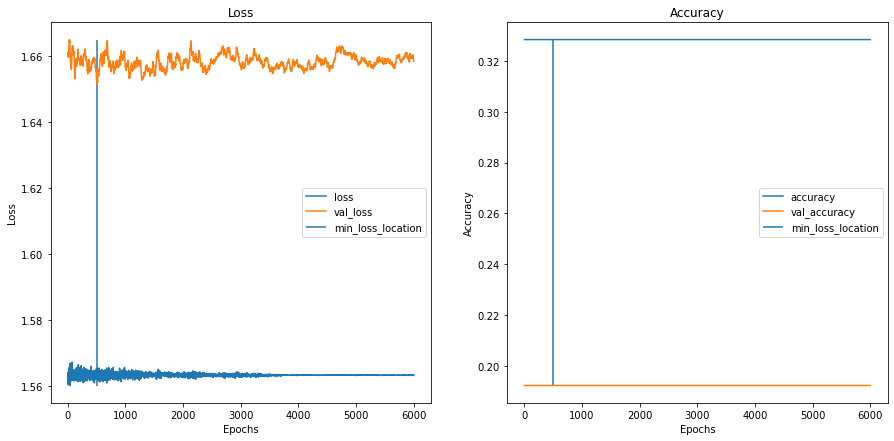

In [30]:
plot_training_curves(history=letters_model)

In [24]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0     